In [1]:
!pip install transformers
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
import pandas as pd

import torchtext.data as ttd

## Loading Dataset

We will use The 20 Newsgroups dataset 
Dataset [homepage](http://qwone.com/~jason/20Newsgroups/): 

Scikit-learn includes some nice helper functions for retrieving the 20 Newsgroups dataset-- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html. We'll use them below to retrieve the dataset.

Also look at results fron non- neural net models here : https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py



In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Dec  1 23:36:51 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train',
                           remove=('headers', 'footers', 'quotes'))

test = fetch_20newsgroups(subset='test',
                           remove=('headers', 'footers', 'quotes'))

In [5]:
print(train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [6]:
print(train.target[0])

7


In [7]:
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [8]:
len(train.target_names)

20

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


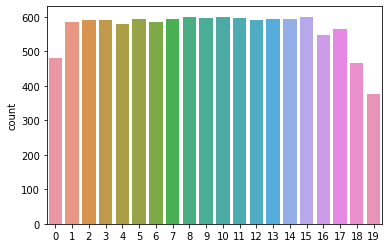

In [9]:
import seaborn as sns

# Plot the number of tokens of each length.
sns.countplot(train.target);

#BERT with 140 features

In [10]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [11]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in train.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True, #Truncate the sentences
                        max_length = 140,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train.target)

# Print sentence 0, now as a list of IDs.
print('Original: ', train.data[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
Token IDs: tensor([  101,  1045,  2001,  6603,  2065,  3087,  2041,  2045,  2071,  4372,
         7138,  2368,  2033,  2006,  2023,  2482,  1045,  2387,  1996,  2060,
         2154,  1012,  2009,  2001,  1037,  1016,  1011,  2341,  2998,  2482,
         1010,  2246,  2000,  2022,  2013,  1996,  2397, 20341,  1013,  2220,
        17549,  1012,  2009,  2001,  2170,  1037,  5318,  4115,  1012,  1996,
         4303,  2020,  2428,  2235,  1012,  1999,  2804,  1010,  1996,  2392,
        21519,  2001,  3584,  2013

In [13]:
test_input_ids = []
test_attention_masks = []

# For every sentence...
for sent in test.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True, #Truncate the sentences
                        max_length = 140,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test.target)

# Print sentence 0, now as a list of IDs.
print('Original: ', test.data[0])
print('Token IDs:', test_input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.
Token IDs: tensor([  101,  1045,  2572,  1037,  2210,  5457,  2006,  2035,  1997,  1996,
         4275,  1997,  1996,  6070,  1011,  6486, 19349, 21187,  2015,  1012,
         1045,  2031,  2657,  1997,  1996,  3393,  7367,  1048,  3366,  7020,
         2063,  7020,  7416,  1012,  2071,  2619,  2425,  2033,  1996,  5966,
         2024,  2521,  2004,  2838,  2030,  2836,  1012,  1045,  2572,  2036,
         8025,  2000,  2113,  2054,  1996,  2338,  3643,  2003,  2005,  9544,
         5243,  6321,  1996,  6486,  2944,  1012, 

In [14]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_dataset)))

10,182 training samples
1,132 validation samples
7,532 test samples


In [15]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = RandomSampler(test_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

In [16]:
from transformers import  BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')

In [17]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [18]:
# Define the model
class linear(nn.Module):

  def __init__(self, bert_model, n_outputs, dropout_rate):
  
    super(linear, self).__init__()

    self.D = bert_model.config.to_dict()['hidden_size']
    self.bert_model = bert_model
    self.K = n_outputs    
    self.dropout_rate=dropout_rate
    
    # embedding layer
    #self.embed = nn.Embedding(self.V, self.D)
    
   
    # dense layer
    self.fc = nn.Linear(self.D , self.K)

    # dropout layer
    self.dropout= nn.Dropout(self.dropout_rate)
  
  def forward(self, X):

    with torch.no_grad():
      embedding = self.bert_model(X)[0][:,0,:]
    
    #embedding= self.dropout(embedding) 

    output = self.fc(embedding)
    output= self.dropout(output)

    return output

In [19]:
n_outputs = 20
dropout_rate = 0.5

In [20]:
#model = RNN(n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model = linear(bert_model, n_outputs, dropout_rate)
model.to(device)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [21]:
print(model)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [22]:
for name, param in model.named_parameters():
  print(name, param.shape)

bert_model.embeddings.word_embeddings.weight torch.Size([30522, 768])
bert_model.embeddings.position_embeddings.weight torch.Size([512, 768])
bert_model.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert_model.embeddings.LayerNorm.weight torch.Size([768])
bert_model.embeddings.LayerNorm.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.query.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.key.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.value.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])

In [23]:
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs=10

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Freeze embedding Layer

#freeze embeddings
#model.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for batch in train_dataloader:
   
    # forward pass
    output= model(batch[0].to(device))
    loss=criterion(output,batch[2].to(device))

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in validation_dataloader:
 
      # forward pass
      output= model(batch[0].to(device))
      loss=criterion(output,batch[2].to(device))
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

Epoch 1/10, Train Loss: 2.7517    Valid Loss: 2.3021, Duration: 0:00:55.957106
Epoch 2/10, Train Loss: 2.5580    Valid Loss: 2.1465, Duration: 0:00:55.912594
Epoch 3/10, Train Loss: 2.4920    Valid Loss: 2.0520, Duration: 0:00:55.919293
Epoch 4/10, Train Loss: 2.4778    Valid Loss: 2.0167, Duration: 0:00:55.986673
Epoch 5/10, Train Loss: 2.4475    Valid Loss: 1.9217, Duration: 0:00:55.934424
Epoch 6/10, Train Loss: 2.4218    Valid Loss: 1.9241, Duration: 0:00:55.974224
Epoch 7/10, Train Loss: 2.4202    Valid Loss: 1.8931, Duration: 0:00:55.915101
Epoch 8/10, Train Loss: 2.4142    Valid Loss: 1.8560, Duration: 0:00:55.933802
Epoch 9/10, Train Loss: 2.4068    Valid Loss: 1.9132, Duration: 0:00:55.909939
Epoch 10/10, Train Loss: 2.3867    Valid Loss: 1.8397, Duration: 0:00:55.986418


In [24]:
# Accuracy- write a function to get accuracy
# use this function to get accuracy and print accuracy
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      correct+= (batch[2].to(device)==indices).sum().item()
      total += batch[2].shape[0]
    
    acc= correct/total

    return acc

In [25]:
train_acc = get_accuracy(train_dataloader, model)
valid_acc = get_accuracy(validation_dataloader, model)
test_acc = get_accuracy(test_dataloader ,model)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.5084,	 Valid acc: 0.4735,	 Test acc: 0.4494


In [26]:
# Write a function to get predictions

def get_predictions(test_iter, model):
  model.eval()
  with torch.no_grad():
    predictions= np.array([])
    y_test= np.array([])

    for batch in test_iter:
      
      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 
      y_test = np.concatenate((y_test,batch[2].numpy())) 
      
  return y_test, predictions

In [27]:
y_test, predictions=get_predictions(test_dataloader, model)

In [28]:
# Confusion Matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[ 54,  16,   0,   2,   0,   0,   1,   1,   4,   0,   1,   5,   0,
         26,  43,  40,   4,  15,  99,   8],
       [  1, 220,   5,  29,   8,  18,   3,   0,   1,   0,   0,  10,   3,
         13,  44,   1,   1,   1,  31,   0],
       [  0, 112,  53,  81,  15,  28,   0,   1,   2,   0,   0,   8,   0,
          9,  50,   1,   1,   1,  32,   0],
       [  0,  67,   3, 228,  27,   0,   4,   2,   3,   0,   0,   6,   1,
         10,  34,   0,   0,   1,   6,   0],
       [  1,  50,   6, 119,  89,   3,   5,   5,   3,   0,   0,   9,   4,
         25,  52,   0,   0,   1,  13,   0],
       [  0, 110,  15,  48,   6, 136,   3,   0,   3,   0,   0,  10,   0,
          6,  32,   0,   0,   0,  26,   0],
       [  0,  58,   0,  57,   6,   0, 178,   6,   5,   0,   0,   6,   1,
         14,  37,   0,   1,   0,  21,   0],
       [  0,  11,   0,  10,   6,   0,   9, 200,  17,   0,   0,   4,   3,
         16,  73,   0,   2,   0,  45,   0],
       [  2,  22,   0,  14,   7,   0,   5,  41, 144,   1,   0,  

In [29]:
# Write a function to print confusion matrix
# plot confusion matrix
# need to import confusion_matrix from sklearn for this function to work
# need to import seaborn as sns
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

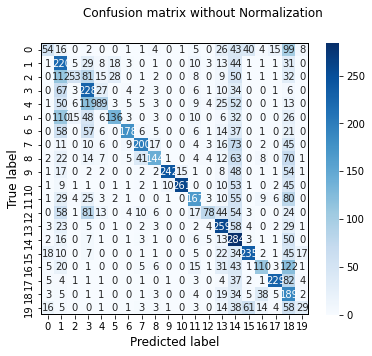

In [30]:
plot_confusion_matrix(y_test,predictions)

#BERT with 128

In [31]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [32]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in train.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True, #Truncate the sentences
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train.target)

# Print sentence 0, now as a list of IDs.
print('Original: ', train.data[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
Token IDs: tensor([  101,  1045,  2001,  6603,  2065,  3087,  2041,  2045,  2071,  4372,
         7138,  2368,  2033,  2006,  2023,  2482,  1045,  2387,  1996,  2060,
         2154,  1012,  2009,  2001,  1037,  1016,  1011,  2341,  2998,  2482,
         1010,  2246,  2000,  2022,  2013,  1996,  2397, 20341,  1013,  2220,
        17549,  1012,  2009,  2001,  2170,  1037,  5318,  4115,  1012,  1996,
         4303,  2020,  2428,  2235,  1012,  1999,  2804,  1010,  1996,  2392,
        21519,  2001,  3584,  2013

In [33]:
test_input_ids = []
test_attention_masks = []

# For every sentence...
for sent in test.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True, #Truncate the sentences
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test.target)

# Print sentence 0, now as a list of IDs.
print('Original: ', test.data[0])
print('Token IDs:', test_input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.
Token IDs: tensor([  101,  1045,  2572,  1037,  2210,  5457,  2006,  2035,  1997,  1996,
         4275,  1997,  1996,  6070,  1011,  6486, 19349, 21187,  2015,  1012,
         1045,  2031,  2657,  1997,  1996,  3393,  7367,  1048,  3366,  7020,
         2063,  7020,  7416,  1012,  2071,  2619,  2425,  2033,  1996,  5966,
         2024,  2521,  2004,  2838,  2030,  2836,  1012,  1045,  2572,  2036,
         8025,  2000,  2113,  2054,  1996,  2338,  3643,  2003,  2005,  9544,
         5243,  6321,  1996,  6486,  2944,  1012, 

In [34]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_dataset)))

10,182 training samples
1,132 validation samples
7,532 test samples


In [35]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = RandomSampler(test_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

In [36]:
from transformers import  BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')

In [37]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [38]:
# Define the model
class linear(nn.Module):

  def __init__(self, bert_model, n_outputs, dropout_rate):
  
    super(linear, self).__init__()

    self.D = bert_model.config.to_dict()['hidden_size']
    self.bert_model = bert_model
    self.K = n_outputs    
    self.dropout_rate=dropout_rate
    
    # embedding layer
    #self.embed = nn.Embedding(self.V, self.D)
    
   
    # dense layer
    self.fc = nn.Linear(self.D , self.K)

    # dropout layer
    self.dropout= nn.Dropout(self.dropout_rate)
  
  def forward(self, X):

    with torch.no_grad():
      embedding = self.bert_model(X)[0][:,0,:]
    
    #embedding= self.dropout(embedding) 

    output = self.fc(embedding)
    output= self.dropout(output)

    return output

In [39]:
n_outputs = 20
dropout_rate = 0.5

In [40]:
#model = RNN(n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model = linear(bert_model, n_outputs, dropout_rate)
model.to(device)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [41]:
print(model)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [42]:
for name, param in model.named_parameters():
  print(name, param.shape)

bert_model.embeddings.word_embeddings.weight torch.Size([30522, 768])
bert_model.embeddings.position_embeddings.weight torch.Size([512, 768])
bert_model.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert_model.embeddings.LayerNorm.weight torch.Size([768])
bert_model.embeddings.LayerNorm.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.query.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.key.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.value.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])

In [43]:
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs=10

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Freeze embedding Layer

#freeze embeddings
#model.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for batch in train_dataloader:
   
    # forward pass
    output= model(batch[0].to(device))
    loss=criterion(output,batch[2].to(device))

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in validation_dataloader:
 
      # forward pass
      output= model(batch[0].to(device))
      loss=criterion(output,batch[2].to(device))
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

Epoch 1/10, Train Loss: 2.7181    Valid Loss: 2.1756, Duration: 0:00:52.097921
Epoch 2/10, Train Loss: 2.5172    Valid Loss: 2.0393, Duration: 0:00:51.956894
Epoch 3/10, Train Loss: 2.4376    Valid Loss: 1.9340, Duration: 0:00:51.921139
Epoch 4/10, Train Loss: 2.4005    Valid Loss: 1.8955, Duration: 0:00:51.917111
Epoch 5/10, Train Loss: 2.3927    Valid Loss: 1.8542, Duration: 0:00:51.926076
Epoch 6/10, Train Loss: 2.3700    Valid Loss: 1.7962, Duration: 0:00:51.939493
Epoch 7/10, Train Loss: 2.3622    Valid Loss: 1.7845, Duration: 0:00:51.973877
Epoch 8/10, Train Loss: 2.3467    Valid Loss: 1.7723, Duration: 0:00:51.916696
Epoch 9/10, Train Loss: 2.3558    Valid Loss: 1.7830, Duration: 0:00:51.929136
Epoch 10/10, Train Loss: 2.3251    Valid Loss: 1.7442, Duration: 0:00:51.955068


In [44]:
# Accuracy- write a function to get accuracy
# use this function to get accuracy and print accuracy
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      correct+= (batch[2].to(device)==indices).sum().item()
      total += batch[2].shape[0]
    
    acc= correct/total

    return acc

In [45]:
train_acc = get_accuracy(train_dataloader, model)
valid_acc = get_accuracy(validation_dataloader, model)
test_acc = get_accuracy(test_dataloader ,model)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.5166,	 Valid acc: 0.4806,	 Test acc: 0.4522


In [46]:
# Write a function to get predictions

def get_predictions(test_iter, model):
  model.eval()
  with torch.no_grad():
    predictions= np.array([])
    y_test= np.array([])

    for batch in test_iter:
      
      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 
      y_test = np.concatenate((y_test,batch[2].numpy())) 
      
  return y_test, predictions

In [47]:
y_test, predictions=get_predictions(test_dataloader, model)

In [48]:
# Confusion Matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[ 58,  35,   0,   0,   0,   0,  22,  18,   1,  15,   0,   7,   0,
         57,   1,  70,  12,  15,   8,   0],
       [  0, 281,   8,   4,   5,   6,  36,   5,   0,  13,   0,   2,   2,
         23,   2,   1,   0,   0,   1,   0],
       [  1, 168, 114,  16,   3,  11,  23,   9,   1,   8,   0,   8,   0,
         30,   0,   0,   2,   0,   0,   0],
       [  0, 129,  28, 125,  14,   2,  41,  13,   0,   5,   0,   3,   6,
         25,   1,   0,   0,   0,   0,   0],
       [  0, 124,  19,  42,  65,   1,  48,  17,   2,   9,   0,   5,   5,
         46,   0,   0,   2,   0,   0,   0],
       [  0, 181,  23,  10,   4, 107,  37,   4,   0,   5,   0,   6,   0,
         15,   1,   0,   1,   1,   0,   0],
       [  0,  43,   3,   3,   1,   0, 303,   6,   1,   9,   0,   2,   1,
         18,   0,   0,   0,   0,   0,   0],
       [  1,  24,   0,   0,   2,   0,  33, 268,   2,  11,   0,   0,   1,
         44,   1,   1,   5,   0,   3,   0],
       [  0,  44,   3,   1,   1,   0,  45, 118,  86,  29,   0,  

In [49]:
# Write a function to print confusion matrix
# plot confusion matrix
# need to import confusion_matrix from sklearn for this function to work
# need to import seaborn as sns
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

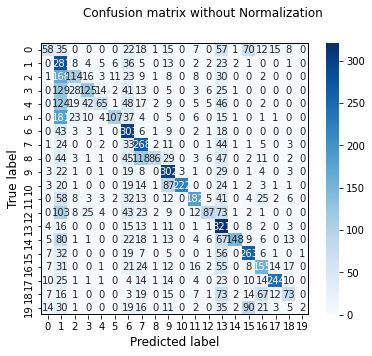

In [50]:
plot_confusion_matrix(y_test,predictions)

#BERT 512 Features

In [51]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [52]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in train.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True, #Truncate the sentences
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(train.target)

# Print sentence 0, now as a list of IDs.
print('Original: ', train.data[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.
Token IDs: tensor([  101,  1045,  2001,  6603,  2065,  3087,  2041,  2045,  2071,  4372,
         7138,  2368,  2033,  2006,  2023,  2482,  1045,  2387,  1996,  2060,
         2154,  1012,  2009,  2001,  1037,  1016,  1011,  2341,  2998,  2482,
         1010,  2246,  2000,  2022,  2013,  1996,  2397, 20341,  1013,  2220,
        17549,  1012,  2009,  2001,  2170,  1037,  5318,  4115,  1012,  1996,
         4303,  2020,  2428,  2235,  1012,  1999,  2804,  1010,  1996,  2392,
        21519,  2001,  3584,  2013

In [53]:
test_input_ids = []
test_attention_masks = []

# For every sentence...
for sent in test.data:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        truncation=True, #Truncate the sentences
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
test_labels = torch.tensor(test.target)

# Print sentence 0, now as a list of IDs.
print('Original: ', test.data[0])
print('Token IDs:', test_input_ids[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.
Token IDs: tensor([  101,  1045,  2572,  1037,  2210,  5457,  2006,  2035,  1997,  1996,
         4275,  1997,  1996,  6070,  1011,  6486, 19349, 21187,  2015,  1012,
         1045,  2031,  2657,  1997,  1996,  3393,  7367,  1048,  3366,  7020,
         2063,  7020,  7416,  1012,  2071,  2619,  2425,  2033,  1996,  5966,
         2024,  2521,  2004,  2838,  2030,  2836,  1012,  1045,  2572,  2036,
         8025,  2000,  2113,  2054,  1996,  2338,  3643,  2003,  2005,  9544,
         5243,  6321,  1996,  6486,  2944,  1012, 

In [54]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(len(test_dataset)))

10,182 training samples
1,132 validation samples
7,532 test samples


In [55]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            test_dataset,  # The training samples.
            sampler = RandomSampler(test_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

In [56]:
from transformers import  BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')

In [57]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [58]:
# Define the model
class linear(nn.Module):

  def __init__(self, bert_model, n_outputs, dropout_rate):
  
    super(linear, self).__init__()

    self.D = bert_model.config.to_dict()['hidden_size']
    self.bert_model = bert_model
    self.K = n_outputs    
    self.dropout_rate=dropout_rate
    
    # embedding layer
    #self.embed = nn.Embedding(self.V, self.D)
    
   
    # dense layer
    self.fc = nn.Linear(self.D , self.K)

    # dropout layer
    self.dropout= nn.Dropout(self.dropout_rate)
  
  def forward(self, X):

    with torch.no_grad():
      embedding = self.bert_model(X)[0][:,0,:]
    
    #embedding= self.dropout(embedding) 

    output = self.fc(embedding)
    output= self.dropout(output)

    return output

In [59]:
n_outputs = 20
dropout_rate = 0.5

In [60]:
#model = RNN(n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs, bidirectional, dropout_rate)
model = linear(bert_model, n_outputs, dropout_rate)
model.to(device)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [61]:
print(model)

linear(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

In [62]:
for name, param in model.named_parameters():
  print(name, param.shape)

bert_model.embeddings.word_embeddings.weight torch.Size([30522, 768])
bert_model.embeddings.position_embeddings.weight torch.Size([512, 768])
bert_model.embeddings.token_type_embeddings.weight torch.Size([2, 768])
bert_model.embeddings.LayerNorm.weight torch.Size([768])
bert_model.embeddings.LayerNorm.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.query.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.query.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.key.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.key.bias torch.Size([768])
bert_model.encoder.layer.0.attention.self.value.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.self.value.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.dense.weight torch.Size([768, 768])
bert_model.encoder.layer.0.attention.output.dense.bias torch.Size([768])
bert_model.encoder.layer.0.attention.output.LayerNorm.weight torch.Size([768])

In [63]:
import random

seed = 123

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

learning_rate = 0.001
epochs=10

# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Freeze embedding Layer

#freeze embeddings
#model.embed.weight.requires_grad  = False

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for batch in train_dataloader:
   
    # forward pass
    output= model(batch[0].to(device))
    loss=criterion(output,batch[2].to(device))

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in validation_dataloader:
 
      # forward pass
      output= model(batch[0].to(device))
      loss=criterion(output,batch[2].to(device))
      
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

Epoch 1/10, Train Loss: 3.0419    Valid Loss: 2.7815, Duration: 0:03:39.286841
Epoch 2/10, Train Loss: 2.9293    Valid Loss: 2.7077, Duration: 0:03:39.195885
Epoch 3/10, Train Loss: 2.8992    Valid Loss: 2.6527, Duration: 0:03:39.192333
Epoch 4/10, Train Loss: 2.8657    Valid Loss: 2.6342, Duration: 0:03:39.245665
Epoch 5/10, Train Loss: 2.8500    Valid Loss: 2.5605, Duration: 0:03:39.192875
Epoch 6/10, Train Loss: 2.8464    Valid Loss: 2.5700, Duration: 0:03:39.200640
Epoch 7/10, Train Loss: 2.8387    Valid Loss: 2.5003, Duration: 0:03:39.328104
Epoch 8/10, Train Loss: 2.8185    Valid Loss: 2.4943, Duration: 0:03:39.246588
Epoch 9/10, Train Loss: 2.8241    Valid Loss: 2.5048, Duration: 0:03:39.224581
Epoch 10/10, Train Loss: 2.8186    Valid Loss: 2.4282, Duration: 0:03:39.227243


In [64]:
# Accuracy- write a function to get accuracy
# use this function to get accuracy and print accuracy
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      correct+= (batch[2].to(device)==indices).sum().item()
      total += batch[2].shape[0]
    
    acc= correct/total

    return acc

In [65]:
train_acc = get_accuracy(train_dataloader, model)
valid_acc = get_accuracy(validation_dataloader, model)
test_acc = get_accuracy(test_dataloader ,model)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.3407,	 Valid acc: 0.3145,	 Test acc: 0.2872


In [66]:
# Write a function to get predictions

def get_predictions(test_iter, model):
  model.eval()
  with torch.no_grad():
    predictions= np.array([])
    y_test= np.array([])

    for batch in test_iter:
      
      output=model(batch[0].to(device))
      _,indices = torch.max(output,dim=1)
      predictions=np.concatenate((predictions,indices.cpu().numpy())) 
      y_test = np.concatenate((y_test,batch[2].numpy())) 
      
  return y_test, predictions

In [67]:
y_test, predictions=get_predictions(test_dataloader, model)

In [68]:
# Confusion Matrix
cm=confusion_matrix(y_test,predictions)
cm

array([[  9,   6,   0,   0,   0,   0,  19,  22,   0,  33,   0,   3,   0,
         55,   0,  69,   9,   8,  75,  11],
       [  0, 111,  26,  17,   0,   5,  69,  36,   0,  32,   1,   2,   2,
         53,   2,   1,   0,   1,  31,   0],
       [  0,  59,  54,  41,   0,  12,  65,  33,   0,  41,   0,   1,   2,
         48,   0,   1,   0,   0,  37,   0],
       [  0,  42,  28,  85,   0,   2,  59,  61,   0,  34,   0,   2,   8,
         41,   1,   0,   0,   1,  28,   0],
       [  0,  51,  10,  48,   3,   0,  68,  59,   0,  41,   0,   0,   4,
         64,   0,   1,   0,   0,  36,   0],
       [  0,  68,  33,  39,   0,  49,  74,  27,   0,  28,   0,   2,   2,
         52,   0,   1,   0,   0,  20,   0],
       [  0,   8,   2,  13,   0,   0, 283,  28,   0,  29,   2,   0,   0,
         17,   0,   0,   0,   0,   8,   0],
       [  0,   9,   0,   2,   0,   0,  51, 205,   0,  55,   1,   1,   1,
         40,   0,   0,   1,   0,  30,   0],
       [  0,  25,   1,   1,   0,   0,  56, 148,  10,  62,   0,  

In [69]:
# Write a function to print confusion matrix
# plot confusion matrix
# need to import confusion_matrix from sklearn for this function to work
# need to import seaborn as sns
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true,y_pred,normalize=None):
  cm=confusion_matrix(y_true,y_pred,normalize=normalize)
  fig, ax = plt.subplots(figsize=(6,5))
  if normalize == None:
    fmt='d'
    fig.suptitle('Confusion matrix without Normalization', fontsize=12)
        
  else :
    fmt='0.2f'
    fig.suptitle('Normalized confusion matrix', fontsize=12)
    
  ax=sns.heatmap(cm,cmap=plt.cm.Blues,annot=True,fmt=fmt)
  ax.axhline(y=0, color='k',linewidth=1)
  ax.axhline(y=cm.shape[1], color='k',linewidth=2)
  ax.axvline(x=0, color='k',linewidth=1)
  ax.axvline(x=cm.shape[0], color='k',linewidth=2)
 
  ax.set_xlabel('Predicted label', fontsize=12)
  ax.set_ylabel('True label', fontsize=12)

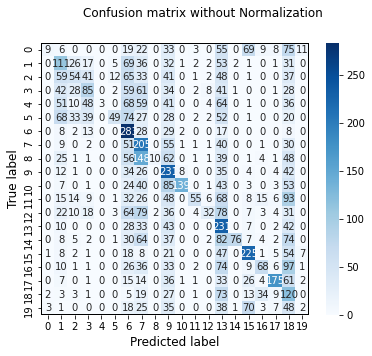

In [70]:
plot_confusion_matrix(y_test,predictions)